In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


from fastai.vision import *
from fastai.callbacks import *

print("is GPU Available?:" ,torch.cuda.is_available())
print("")

!nvidia-smi

import torch
defaults.device = torch.device("cuda:0")
#torch.cuda.empty_cache()

is GPU Available?: True

Thu Dec 17 06:03:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00009803:00:00.0 Off |                  Off |
| N/A   53C    P0    72W / 149W |   3140MiB / 12206MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                   

In [5]:
from fastai.vision import zoom_crop
from fastai.vision import cutout
from fastai.vision import get_transforms

class cfg:
    epochs = 15
    experimentname = 'r50_synth_flkr_x01_121720'
    model = 'resnet50'
    
    
    data_train_folder = '/mnt/omreast_users/phhale/csiro_trashnet/datasets/crop_ds0/v3_flikr/synth_flkr/'
    model_save_path = '/mnt/omreast_users/phhale/csiro_trashnet/experiments/classifer_fastai/dev_models/'
    
    tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), 
                                     jitter(magnitude=0.005, p=.25)])

    
    batch_size = 16 #128
    img_input_size = 150
    model_pretrain = True
    
    model_metrics = [accuracy, error_rate, FBeta(beta=1),
             Precision(average='micro'), Recall(average='micro')]

    

cfg = cfg()

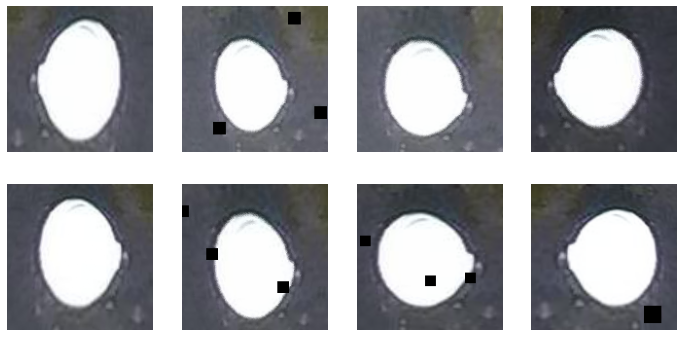

In [4]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]
    
DATA_DIR = Path("/mnt/omreast_users/phhale/csiro_trashnet")
#open_image(DATA_DIR/'datasets/crop_ds0/v3_flikr/csiro_syn_flkr/D_lid/csiro_D_lid_001223.jpg').show()

plots_f(DATA_DIR/'datasets/crop_ds0/v3_flikr/csiro_syn_flkr/D_lid/csiro_D_lid_001223.jpg', 
        cfg.tfms, 2, 4, 12, 6, size=150)

In [6]:
from customDataset import get_csiro_dataset
data = get_csiro_dataset(dataset_path=cfg.data_train_folder, tfms=cfg.tfms, 
                         bs=cfg.batch_size, sz=cfg.img_input_size)

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


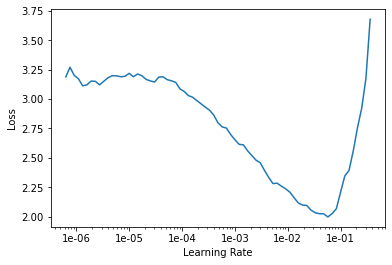

In [7]:
learn = cnn_learner(data, models.resnet50, 
                    path=cfg.model_save_path,
                    metrics=cfg.model_metrics)
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,precision,recall,time
0,0.710801,0.462667,0.885124,0.114876,0.845550,0.885124,0.885124,01:39
1,0.452440,0.254465,0.926446,0.073554,0.891637,0.926446,0.926446,00:51
2,0.398415,0.225769,0.930579,0.069421,0.900176,0.930578,0.930578,00:51
3,0.251791,0.190383,0.942975,0.057025,0.908229,0.942975,0.942975,00:51
4,0.239432,0.178498,0.946281,0.053719,0.918014,0.946281,0.946281,00:54


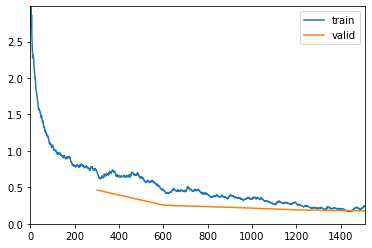

In [10]:
stage1_callbacks = [CSVLogger(learn=learn, filename=f'experiment_results/{cfg.experimentname}-stage1-history'), 
                               ShowGraph(learn=learn)]
lr = (1e-2)/2
learn.fit_one_cycle(5, slice(lr), callbacks=stage1_callbacks)

In [11]:

learn.save(f'{cfg.experimentname}-_im150-stage1')
learn.export(f'exported_models/{cfg.experimentname}-_im150-stage1.pkl')

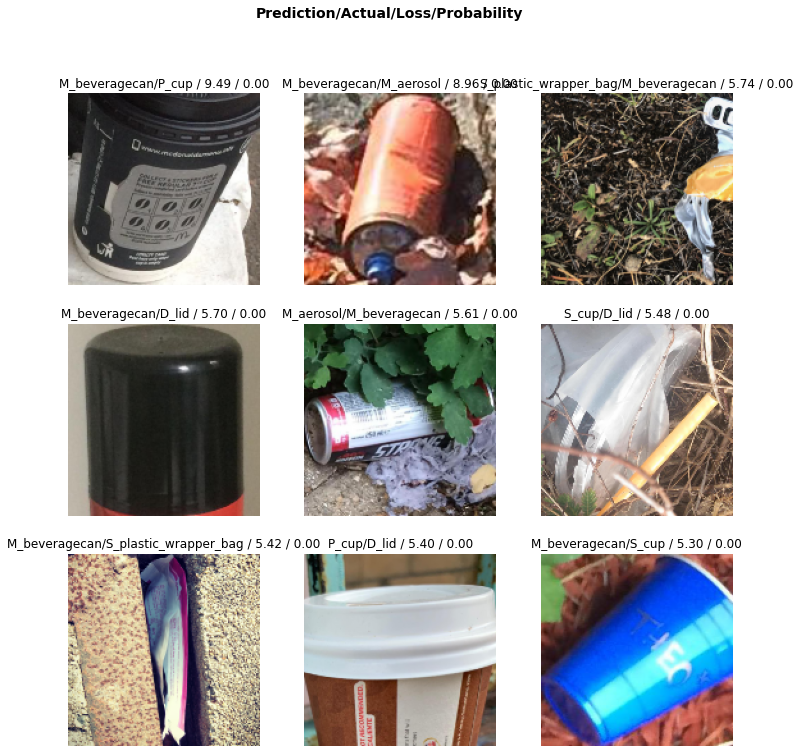

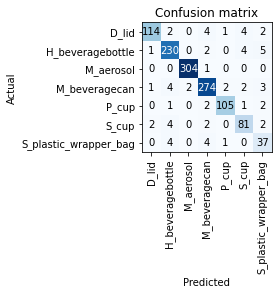

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)
interp.plot_confusion_matrix()

In [13]:
learn.freeze()
learn.load('stage1')

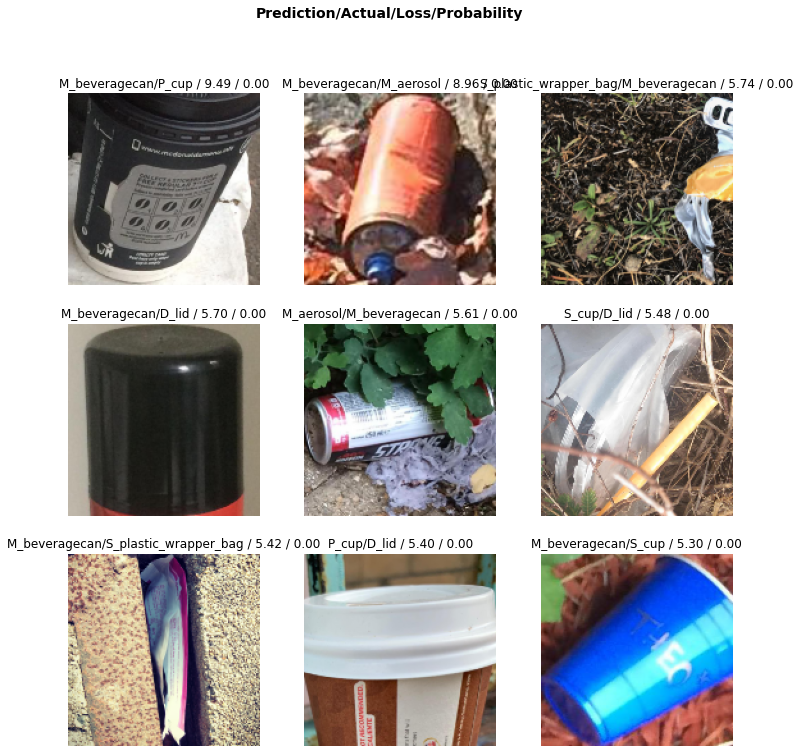

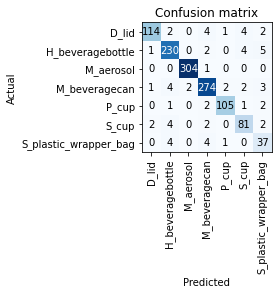

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9)
interp.plot_confusion_matrix()

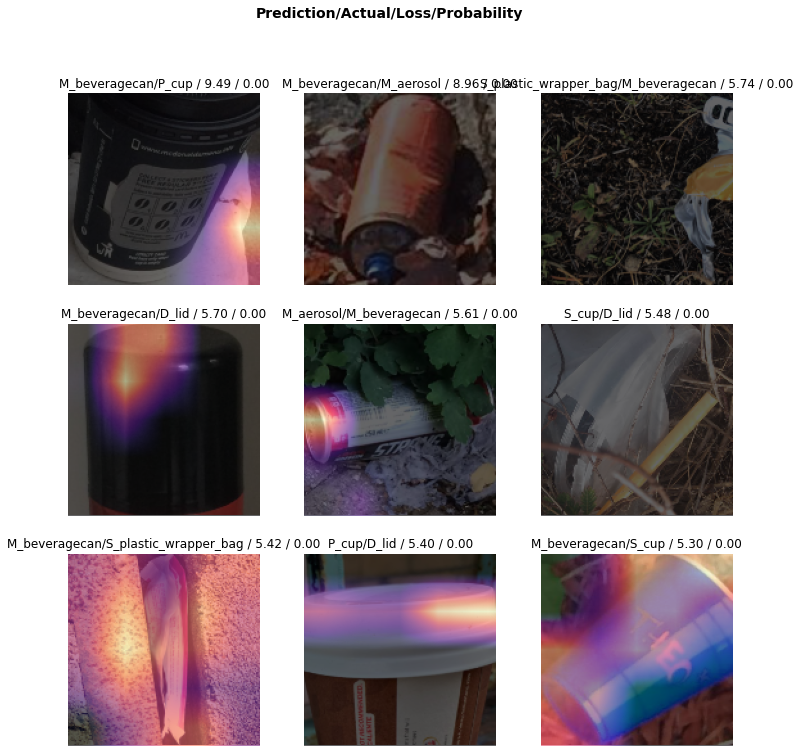

In [18]:
interp.plot_top_losses(9,heatmap=True)

## eval on ValVideo

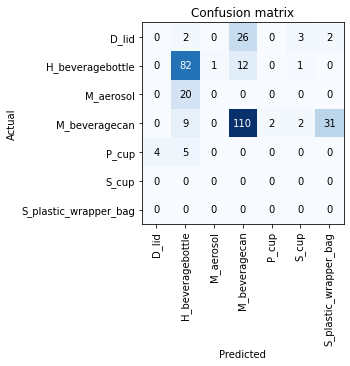

In [19]:
#MNT_TEST_SET = '/mnt/omreast_users/phhale/csiro_trashnet/original_samples/ValidationVideo/crop_ds2_test/test/'
MNT_TEST_SET ='/mnt/omreast_users/phhale/csiro_trashnet/original_samples/ValidationVideo/crops_ds2_only'
test_data = get_csiro_dataset(dataset_path=MNT_TEST_SET, tfms=None, bs=8, sz=cfg.img_input_size,
                                    train_mode=False)
#ROOT_PATH = '/mnt/omreast_users/phhale/csiro_trashnet/datasets/crop_ds0/v2/crop_images/models/model_export/'
test_learn = load_learner(path=cfg.model_save_path,
                     file = f'exported_models/{cfg.experimentname}-_im150-stage1.pkl').to_fp32()

#test_data.train_dl
test_learn.data.test_dl = test_data.train_dl
#learn.data.test_ds
interp_test = ClassificationInterpretation.from_learner(learn=test_learn, ds_type=DatasetType.Test)
interp_test.plot_confusion_matrix(figsize = (25,5))

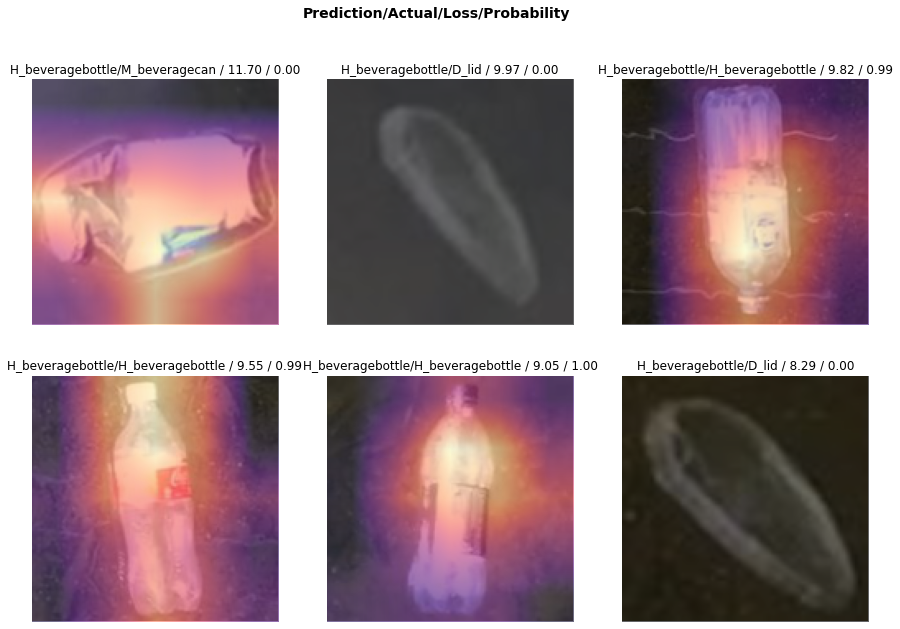

In [35]:
interp_test.plot_top_losses(6, heatmap=True, figsize=(15, 10))

308 misclassified samples over 1 samples in the validation set.


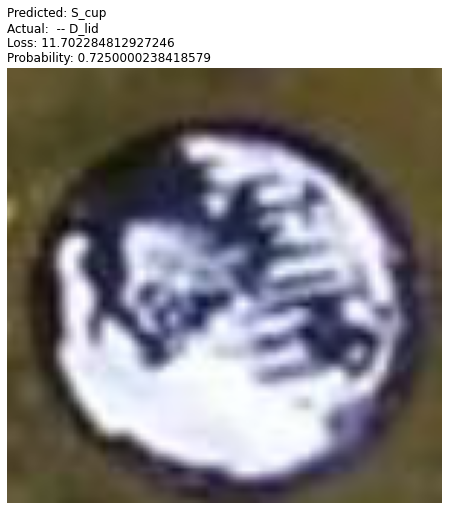

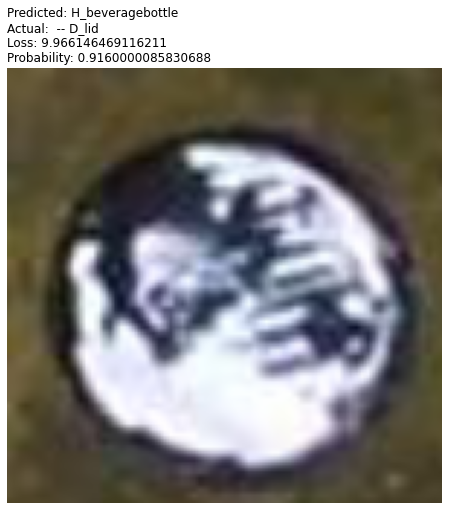

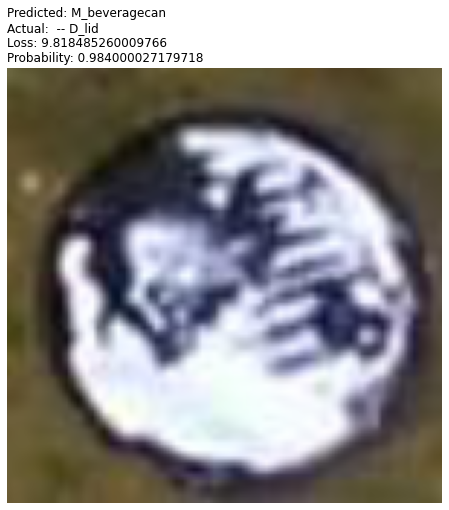

In [27]:
interp_test.plot_multi_top_losses()